In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math
from datetime import datetime

In [2]:
sns.set(style='darkgrid')
sns.set(rc={'figure.figsize':(15,8)})

In [3]:
# read factors
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
factors_returns = pd.read_csv('factors_returns.csv', index_col=0, 
                      parse_dates=True, date_parser=dateparse)
strategy_returns = pd.read_csv('strategy_returns.csv', index_col=0, 
                      parse_dates=True, date_parser=dateparse)

In [4]:
def freward(weights):
    pred_returns = (1 + (weights * factors_returns).sum(axis=1)).cumprod(
        ).pct_change().fillna(0)
    tracking_error =  (pred_returns.values - strategy_returns.iloc[:,0].values)
    return -np.sqrt(np.mean(tracking_error**2))

In [5]:
def freward_teacher(weights):
    pred_returns = (1 + (weights * factors_returns).sum(axis=1)).cumprod(
        ).pct_change().fillna(0)
    tracking_error =  (pred_returns.values - strategy_returns.iloc[:,0].values
        ) * np.sqrt(250) * np.sqrt(weights.shape[1]+1)
    turn_over = 0.0020 * 365 * ((weights - weights.shift(1)).abs().fillna(0).values
        ) / ((weights.index[-1] -weights.index[0]).days) * np.sqrt(
        weights.shape[0] * (weights.shape[1]+1)) 
    error_terms = np.concatenate([tracking_error, turn_over.flatten()], axis=0)
    return -np.sqrt(np.mean(error_terms**2))

In [6]:
strategy_returns.head(10)

,Last Price
Date,
2010-01-04,0.000000
2010-01-05,0.002270
2010-01-06,0.004127
2010-01-07,0.000179
2010-01-08,0.001401
2010-01-11,0.002056
2010-01-12,-0.001762
2010-01-13,-0.000401
2010-01-14,0.001357


In [7]:
def buildPrices(dataframe,base):
    df= pd.DataFrame()
    for name in dataframe.columns:
        df[name+' price']= base * (1 + dataframe[name]).cumprod()
    return df

In [8]:
0.1/ np.sqrt(250)

0.006324555320336759

In [9]:
# read factors
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
factors_returns = pd.read_csv('factors_returns.csv', index_col=0, 
                      parse_dates=True, date_parser=dateparse)
strategy_returns = pd.read_csv('strategy_returns.csv', index_col=0, 
                      parse_dates=True, date_parser=dateparse)

# create simple random weights (equal weight plus some noise 4% per annum)
data = np.tile( [1/factors_returns.shape[1]] * factors_returns.shape[1], 
               factors_returns.shape[0]).reshape(factors_returns.shape)
weights = pd.DataFrame(index=factors_returns.index, columns = factors_returns.columns, data=data)
weights += np.random.normal(0, 0.04/ np.sqrt(250), weights.shape)
print(strategy_returns)

            Last Price
Date                  
2010-01-04    0.000000
2010-01-05    0.002270
2010-01-06    0.004127
2010-01-07    0.000179
2010-01-08    0.001401
...                ...
2022-02-03   -0.002747
2022-02-04   -0.000319
2022-02-07    0.000347
2022-02-08    0.001770
2022-02-09    0.003407

[3058 rows x 1 columns]


In [10]:
 factors_returns.head()

,Bloomberg Commodities,Dollar Index,EM Bond USD,EU Global Aggregate,EU HY,EU Stoxx 600,Japan Nikkei 225,MSCI EM USD,US Global Aggregate,US HY,US S&P 500
Date,,,,,,,,,,,
2010-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-05,-0.001329,0.000467,0.004215,0.001062,0.007361,-0.000215,0.002538,0.010706,0.004409,0.002218,0.003119
2010-01-06,0.020527,0.000061,0.000460,-0.000679,0.006578,0.001435,0.004645,0.006396,-0.000904,0.007291,0.000850
2010-01-07,-0.015051,0.005292,-0.000300,0.001803,0.006402,0.000334,-0.004640,-0.007172,-0.000517,0.003488,0.004046
2010-01-08,-0.003042,-0.004810,0.000482,0.000787,0.004789,0.004298,0.010921,0.001963,0.000899,0.003684,0.002880


In [11]:
df = buildPrices(factors_returns,100)

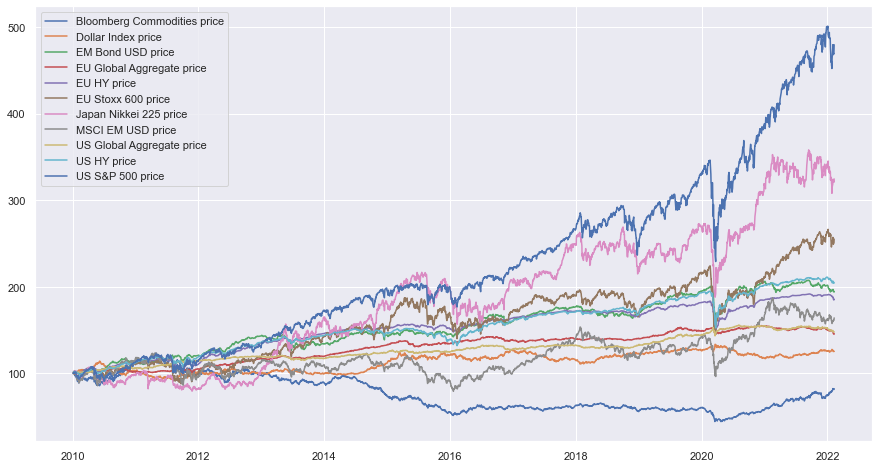

In [12]:
plt.plot(df)
plt.legend(df.columns,loc='upper left')

In [13]:
df['Strategy price']= 100 * (1 + strategy_returns['Last Price']).cumprod()

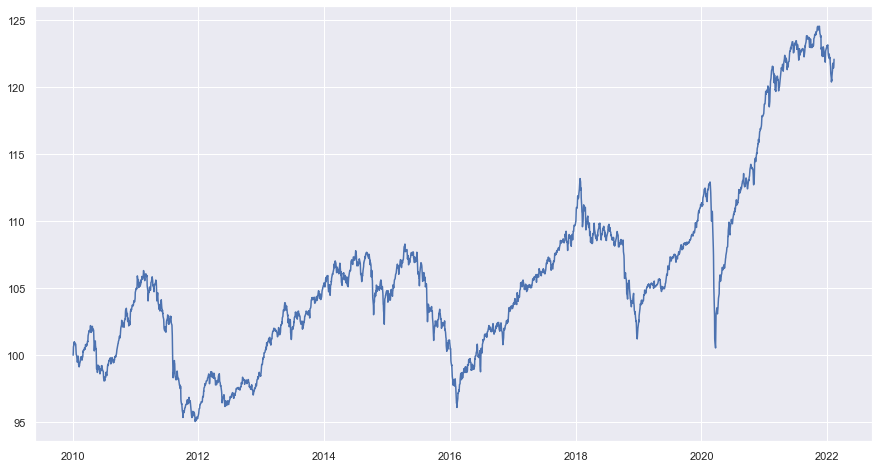

In [14]:
plt.plot(df['Strategy price'])

# DDPG

In [15]:
import sys
import copy
import matplotlib.pyplot as plt
from itertools import count
from datetime import datetime
from envmkt import Decode_v1
from ddpg import DDPGagent
from utils import *

C:\Users\duzen\anaconda3\envs\torch_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
env = Decode_v1(factors_returns=factors_returns,strategy_returns=strategy_returns,random_start=False,window=7)

In [17]:
agent = DDPGagent(env)
noise = OUNoise(env.action_space)
batch_size = 128
nb_episodes = 256

In [18]:
rewards = []
avg_rewards = []
best_env = env
best_reward = -100

for episode in range(nb_episodes):
    state = env.reset()
    noise.reset()
    episode_reward = 0
    
    for step in count():
        action = agent.get_action(state)
        action = noise.get_action(action, step)
        if step % 1500 ==0:
            print(action)
            print(np.linalg.norm(action))
        new_state, reward, done, _ = env.step(action) 
        agent.memory.push(state, action, reward, new_state, done)
        
        if len(agent.memory) > batch_size:
            agent.update(batch_size)        
        
        state = new_state 
        episode_reward += reward 

        if done:
            sys.stdout.write("episode: {}, reward: {}, average _reward: {} \n".format(episode, np.round(episode_reward, decimals=2), np.mean(rewards[-10:])))
            print(f'Env reward is {freward_teacher(env.weights_df)}')
            if freward_teacher(env.weights_df) > best_reward :
                best_env = copy.deepcopy(env)
                best_reward = freward_teacher(env.weights_df)
                print(f'best reward has been set to {best_reward}')
                print('\x1b[6;30;42m' + 'best_env has been changed' + '\x1b[0m')
            break

    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards))

[ 0.03479985 -0.00162473  0.0077911  -0.00972974 -0.01710194 -0.02555939
  0.04726837 -0.06601785  0.02812253 -0.11610878  0.04021751]
0.15747071603782506
[ 0.03315431 -0.03441602 -0.02052844 -0.0155428  -0.01480058  0.03530642
 -0.0335305  -0.07149188  0.01176147 -0.07217228  0.01354566]
0.12719396488735638
[ 0.03328855 -0.02729218 -0.18901978 -0.04651782 -0.11471198 -0.01479563
 -0.05275909 -0.11981191 -0.0471674  -0.01651734 -0.02055076]
0.2705207160100683


C:\Users\duzen\anaconda3\envs\torch_env\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\duzen\anaconda3\envs\torch_env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


episode: 0, reward: -9.08, average _reward: nan 
Env reward is -0.044365176222573674
best reward has been set to -0.044365176222573674
best_env has been changed
[ 0.02263133 -0.02788759 -0.15392788  0.00928842 -0.12270062 -0.008624
 -0.04486566 -0.09683068 -0.04725319 -0.06702001 -0.00655566]
0.24157070777281972
[ 0.03171914 -0.03651194 -0.01884939  0.00352121 -0.01763733 -0.035191
  0.00614178 -0.06614879  0.00872427 -0.0461914   0.00416216]
0.1043880808971748
[ 0.00564002 -0.00494759  0.01944897 -0.01032359 -0.05961756 -0.05788103
 -0.01141961 -0.06436074 -0.0665035  -0.08632858 -0.01695615]
0.15453529676396935
episode: 1, reward: -7.58, average _reward: -9.076857644117108 
Env reward is -0.047793915372820156
[-0.01007856 -0.05163833 -0.022634    0.00416793 -0.07955902 -0.0826144
 -0.06191372 -0.04686234 -0.07623966 -0.02904378 -0.01381386]
0.17125646790119445
[ 0.07402432 -0.03010142 -0.0363855   0.01588223 -0.00317162  0.01350853
 -0.02160828 -0.07002905 -0.00452314  0.00283164  0.

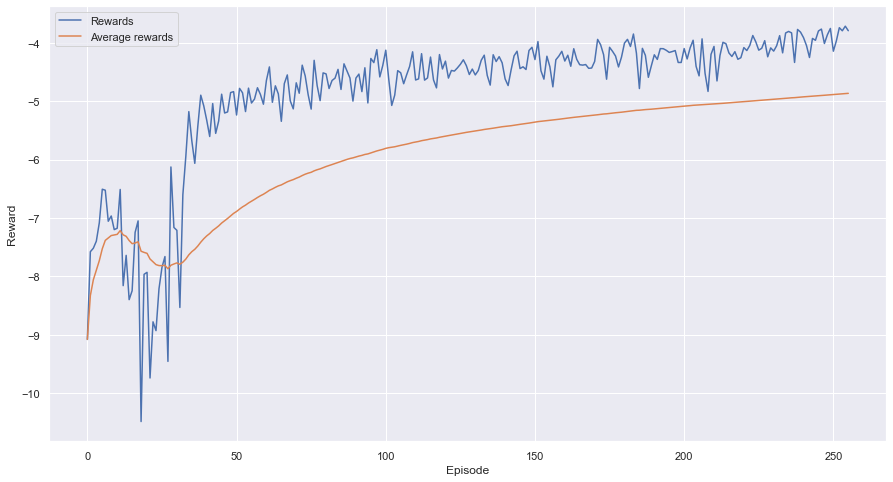

In [19]:
plt.plot(rewards,label='Rewards')
plt.plot(avg_rewards,label='Average rewards')
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()

In [20]:
weights_predicted = best_env.weights_df 

In [21]:
freward_teacher(weights_predicted)

-0.020908967423082826

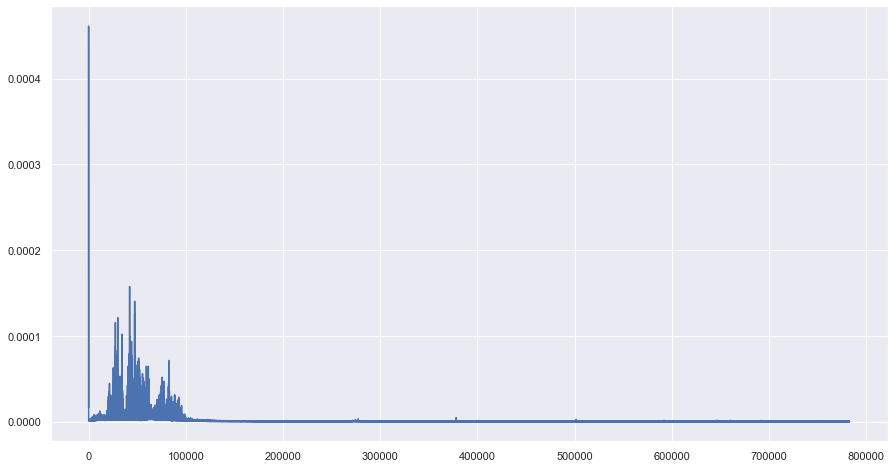

In [22]:
plt.plot(range(len(agent.critic_losses)),agent.critic_losses)
plt.show()

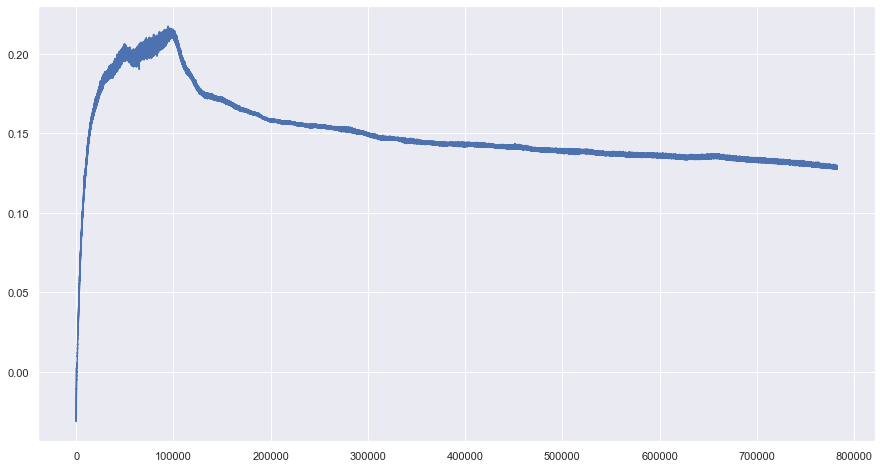

In [23]:
plt.plot(range(len(agent.actor_losses)),agent.actor_losses)
plt.show()

In [24]:
weights_predicted.head(20)

,Bloomberg Commodities,Dollar Index,EM Bond USD,EU Global Aggregate,EU HY,EU Stoxx 600,Japan Nikkei 225,MSCI EM USD,US Global Aggregate,US HY,US S&P 500
Date,,,,,,,,,,,
2010-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-05,0.012562,0.044516,0.022228,0.061663,0.022404,0.034723,0.013473,0.06523,0.05861,0.074918,0.061727
2010-01-06,0.013799,0.043741,0.023264,0.065054,0.02923,0.032844,0.013896,0.063241,0.059215,0.073828,0.065184
2010-01-07,0.012818,0.045813,0.024694,0.064541,0.027028,0.031155,0.008298,0.065683,0.057362,0.075176,0.062963
2010-01-08,0.009048,0.048422,0.029297,0.063182,0.024094,0.030964,0.00781,0.069044,0.056514,0.071458,0.062922
2010-01-11,0.012619,0.051043,0.027718,0.060395,0.023226,0.028331,0.004477,0.068276,0.053759,0.072364,0.06442
2010-01-12,0.012335,0.048805,0.029461,0.063149,0.026564,0.028753,0.007449,0.066496,0.058117,0.065361,0.058676
2010-01-13,0.012922,0.043924,0.030749,0.066178,0.024005,0.026824,0.010904,0.066725,0.061392,0.064041,0.060648
2010-01-14,0.011722,0.045444,0.025668,0.069148,0.028591,0.028364,0.01079,0.064889,0.059704,0.065693,0.062571


In [25]:
pred_returns = pd.DataFrame()
pred_returns['Last Price'] = (1 + (weights_predicted * factors_returns).sum(axis=1)).cumprod().pct_change().fillna(0)

In [26]:
pred_returns.head()

,Last Price
Date,
2010-01-04,0.000000
2010-01-05,0.001670
2010-01-06,0.001501
2010-01-07,0.000320
2010-01-08,0.000768


In [27]:
df['Agent price']= 100 * (1 + pred_returns['Last Price']).cumprod()

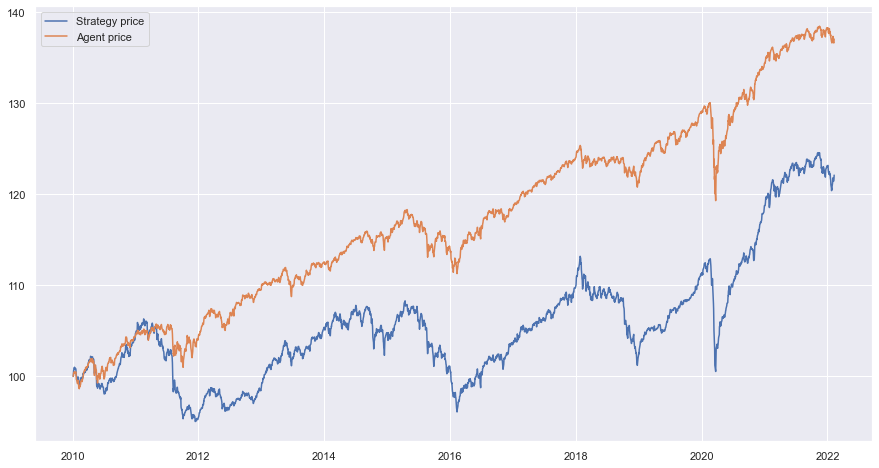

In [28]:
plt.plot(df[['Strategy price','Agent price']])
plt.legend(df[['Strategy price','Agent price']].columns,loc='upper left')

In [37]:
def create_submission(weights, factors_returns):
    # some financial computations
    weight_abs_diff = (weights - weights.shift(1)).abs().fillna(0)
    weight_abs_diff*= 0.0025 * 365 / ((weights.index[-1] - weights.index[0]).days) * np.sqrt(
        weights.shape[0] * (weights.shape[1]+1))
    pred_returns = (1 + (weights * factors_returns).sum(axis=1)).cumprod(
        ).pct_change().fillna(0)
    pred_returns*= np.sqrt(250) * np.sqrt(weights.shape[1]+1)
                    
    # format submission
    submission = pred_returns.to_frame() 
    submission.columns = ['Expected']
    submission.index = ['{:%Y-%m-%d}'.format(x) + '_returns' for x in pred_returns.index]
    
    for col in weight_abs_diff.columns:
        tmp = weight_abs_diff[col].to_frame()
        tmp.columns = ['Expected']
        tmp.index = [ '{:%Y-%m-%d}'.format(x) + '_{:}'.format(col) for x in tmp.index]
        submission = pd.concat([submission, tmp], axis=0)
    submission.index.names = ['Id']
    return submission
                    

In [38]:
submission = create_submission(best_env.weights_df , factors_returns)

In [39]:
submission.to_csv('submission.csv')